### Обнаружение статистически значимых отличий в уровнях экспрессии генов больных раком

In [1]:
import os
import tqdm
import scipy
import statsmodels as stm
import numpy as np
import pandas as pd
import seaborn as sns
import multiprocessing as mp
import matplotlib.pyplot as plt

from statsmodels.stats import multitest

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

In [2]:
# Версии использованных пакетов.
%load_ext watermark
%watermark -v -p scipy,statsmodels,numpy,pandas,matplotlib,seaborn

CPython 3.7.6
IPython 7.13.0

scipy 1.4.1
statsmodels 0.11.1
numpy 1.18.2
pandas 1.0.3
matplotlib 3.2.1
seaborn 0.10.0


In [3]:
# Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.
%load_ext autoreload
%autoreload 2

#### Общее описание исследования

Данные для этой задачи взяты из исследования, проведенного в Stanford School of Medicine. В исследовании была предпринята попытка выявить набор генов, которые позволили бы более точно диагностировать возникновение рака груди на самых ранних стадиях.

В эксперименте принимали участие 24 человека, у которых не было рака груди (normal), 25 человек, у которых это заболевание было диагностировано на ранней стадии (early neoplasia), и 23 человека с сильно выраженными симптомами (cancer).

Ученые провели секвенирование биологического материала испытуемых, чтобы понять, какие из этих генов наиболее активны в клетках больных людей.

Секвенирование — это определение степени активности генов в анализируемом образце с помощью подсчёта количества соответствующей каждому гену РНК.

В данных для этого задания вы найдете именно эту количественную меру активности каждого из 15748 генов у каждого из 72 человек, принимавших участие в эксперименте.

#### Цель исследования

Цель  — найти гены, средняя экспрессия которых отличается не только статистически значимо, но и достаточно сильно. В экспрессионных исследованиях для этого часто используется метрика, которая называется __fold change__(кратность изменения). 

$$
\begin{equation}
       F_{c}(C, T) = 
        \begin{cases}
            \frac{T}{C}, & \text{if T>C} \\
            -\frac{C}{T}, & \text{if T<C} \\
        \end{cases}
    \end{equation}
    $$

где $C,T$ — средние значения экспрессии гена в control и treatment группах соответственно. По сути, fold change показывает, во сколько раз отличаются средние двух выборок.

#### Задачи

Вам нужно будет определить те гены, активность которых у людей в разных стадиях заболевания отличается статистически значимо.

Кроме того, вам нужно будет оценить не только статистическую, но и практическую значимость этих результатов, которая часто используется в подобных исследованиях.

Задание состоит из трёх частей. Если не сказано обратное, то уровень значимости нужно принять равным __`0.05`__.




1. Использовать критерий Стьюдента для проверки гипотезы о равенстве средних в двух независимых выборках. Применить критерий для каждого гена нужно будет дважды:

    * для групп normal (control) и early neoplasia (treatment)
    * для групп early neoplasia (control) и cancer (treatment)

В качестве ответа в этой части задания необходимо указать количество статистически значимых отличий, которые вы нашли с помощью t-критерия Стьюдента, то есть __число генов, у которых p-value этого теста оказался меньше, чем уровень значимости.__

2. Применить поправку Холма для получившихся двух наборов достигаемых уровней значимости из предыдущей части. Обратите внимание, что __поскольку вы будете делать поправку для каждого из двух наборов p-value отдельно, то проблема, связанная с множественной проверкой останется.__

Для того, __чтобы ее устранить, достаточно воспользоваться поправкой Бонферрони__, то есть использовать уровень значимости 0.05 / 2 вместо 0.05 для дальнейшего уточнения значений p-value c помощью метода Холма.

В качестве ответа к этому заданию требуется ввести __количество значимых отличий в каждой группе после того, как произведена коррекция Холма-Бонферрони. Причем это число нужно ввести с учетом практической значимости__: посчитайте для каждого значимого изменения fold change и выпишите в ответ число таких значимых изменений, абсолютное значение fold change > 1.5.

Обратите внимание, что:
 * применять поправку на множественную проверку нужно ко всем значениям достигаемых уровней значимости, а не только для тех, которые меньше значения уровня доверия.
 * при использовании поправки на уровне значимости 0.025 меняются значения достигаемого уровня значимости, но не меняется значение уровня доверия (то есть для отбора значимых изменений скорректированные значения уровня значимости нужно сравнивать с порогом __0.025, а не 0.05__)! 


3. Данная часть задания аналогична второй части за исключением того, что нужно будет использовать метод Бенджамини-Хохберга.

Обратите внимание, что методы коррекции, которые контролируют FDR, допускает больше ошибок первого рода и имеют большую мощность, чем методы, контролирующие FWER. Большая мощность означает, что эти методы будут совершать меньше ошибок второго рода (то есть будут лучше улавливать отклонения от $H_0$, когда они есть, и будут чаще отклонять $H_0$, когда отличий нет).

В качестве __ответа к этому заданию требуется ввести количество значимых отличий в каждой группе после того, как произведена коррекция Бенджамини-Хохберга__, причем так же, как и во второй части, считать только такие отличия, у которых abs(fold change) > 1.5. 

P.S. Вспомните, какое значение имеет уровень значимости $\alpha$ в каждой из поправок: Холма и Бенджамини-Хохберга. Одинаковый ли смысл имеет уровень значимости в каждой из поправок?

---
Чтение данных

In [4]:
df = pd.read_csv('gene_high_throughput_sequencing.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Columns: 15750 entries, Patient_id to EIF1AY
dtypes: float64(15748), object(2)
memory usage: 8.7+ MB


In [6]:
df.head()

,Patient_id,Diagnosis,LOC643837,LOC100130417,SAMD11,NOC2L,KLHL17,PLEKHN1,C1orf170,HES4,...,CLIC2,RPS4Y1,ZFY,PRKY,USP9Y,DDX3Y,CD24,CYorf15B,KDM5D,EIF1AY
0,STT5425_Breast_001_normal,normal,1.257614,2.408148,13.368622,9.494779,20.880435,12.722017,9.494779,54.349694,...,4.761250,1.257614,1.257614,1.257614,1.257614,1.257614,23.268694,1.257614,1.257614,1.257614
1,STT5427_Breast_023_normal,normal,4.567931,16.602734,42.477752,25.562376,23.221137,11.622386,14.330573,72.445474,...,6.871902,1.815112,1.815112,1.815112,1.815112,1.815112,10.427023,1.815112,1.815112,1.815112
2,STT5430_Breast_002_normal,normal,2.077597,3.978294,12.863214,13.728915,14.543176,14.141907,6.232790,57.011005,...,7.096343,2.077597,2.077597,2.077597,2.077597,2.077597,22.344226,2.077597,2.077597,2.077597
3,STT5439_Breast_003_normal,normal,2.066576,8.520713,14.466035,7.823932,8.520713,2.066576,10.870009,53.292034,...,5.200770,2.066576,2.066576,2.066576,2.066576,2.066576,49.295538,2.066576,2.066576,2.066576
4,STT5441_Breast_004_normal,normal,2.613616,3.434965,12.682222,10.543189,26.688686,12.484822,1.364917,67.140393,...,11.227770,1.364917,1.364917,1.364917,1.364917,1.364917,23.627911,1.364917,1.364917,1.364917


In [7]:
df['Diagnosis'].value_counts()

early neoplasia    25
normal             24
cancer             23
Name: Diagnosis, dtype: int64

Рассмотрим в первом приближении распределение и Q-Q-графики экспрессии случайной подвыборки генов по группам, зафиксировав seed=42 для возможности вовзращения к конкретной подвыборе, а также сторонней воспроизводимости результатов matplotlib.

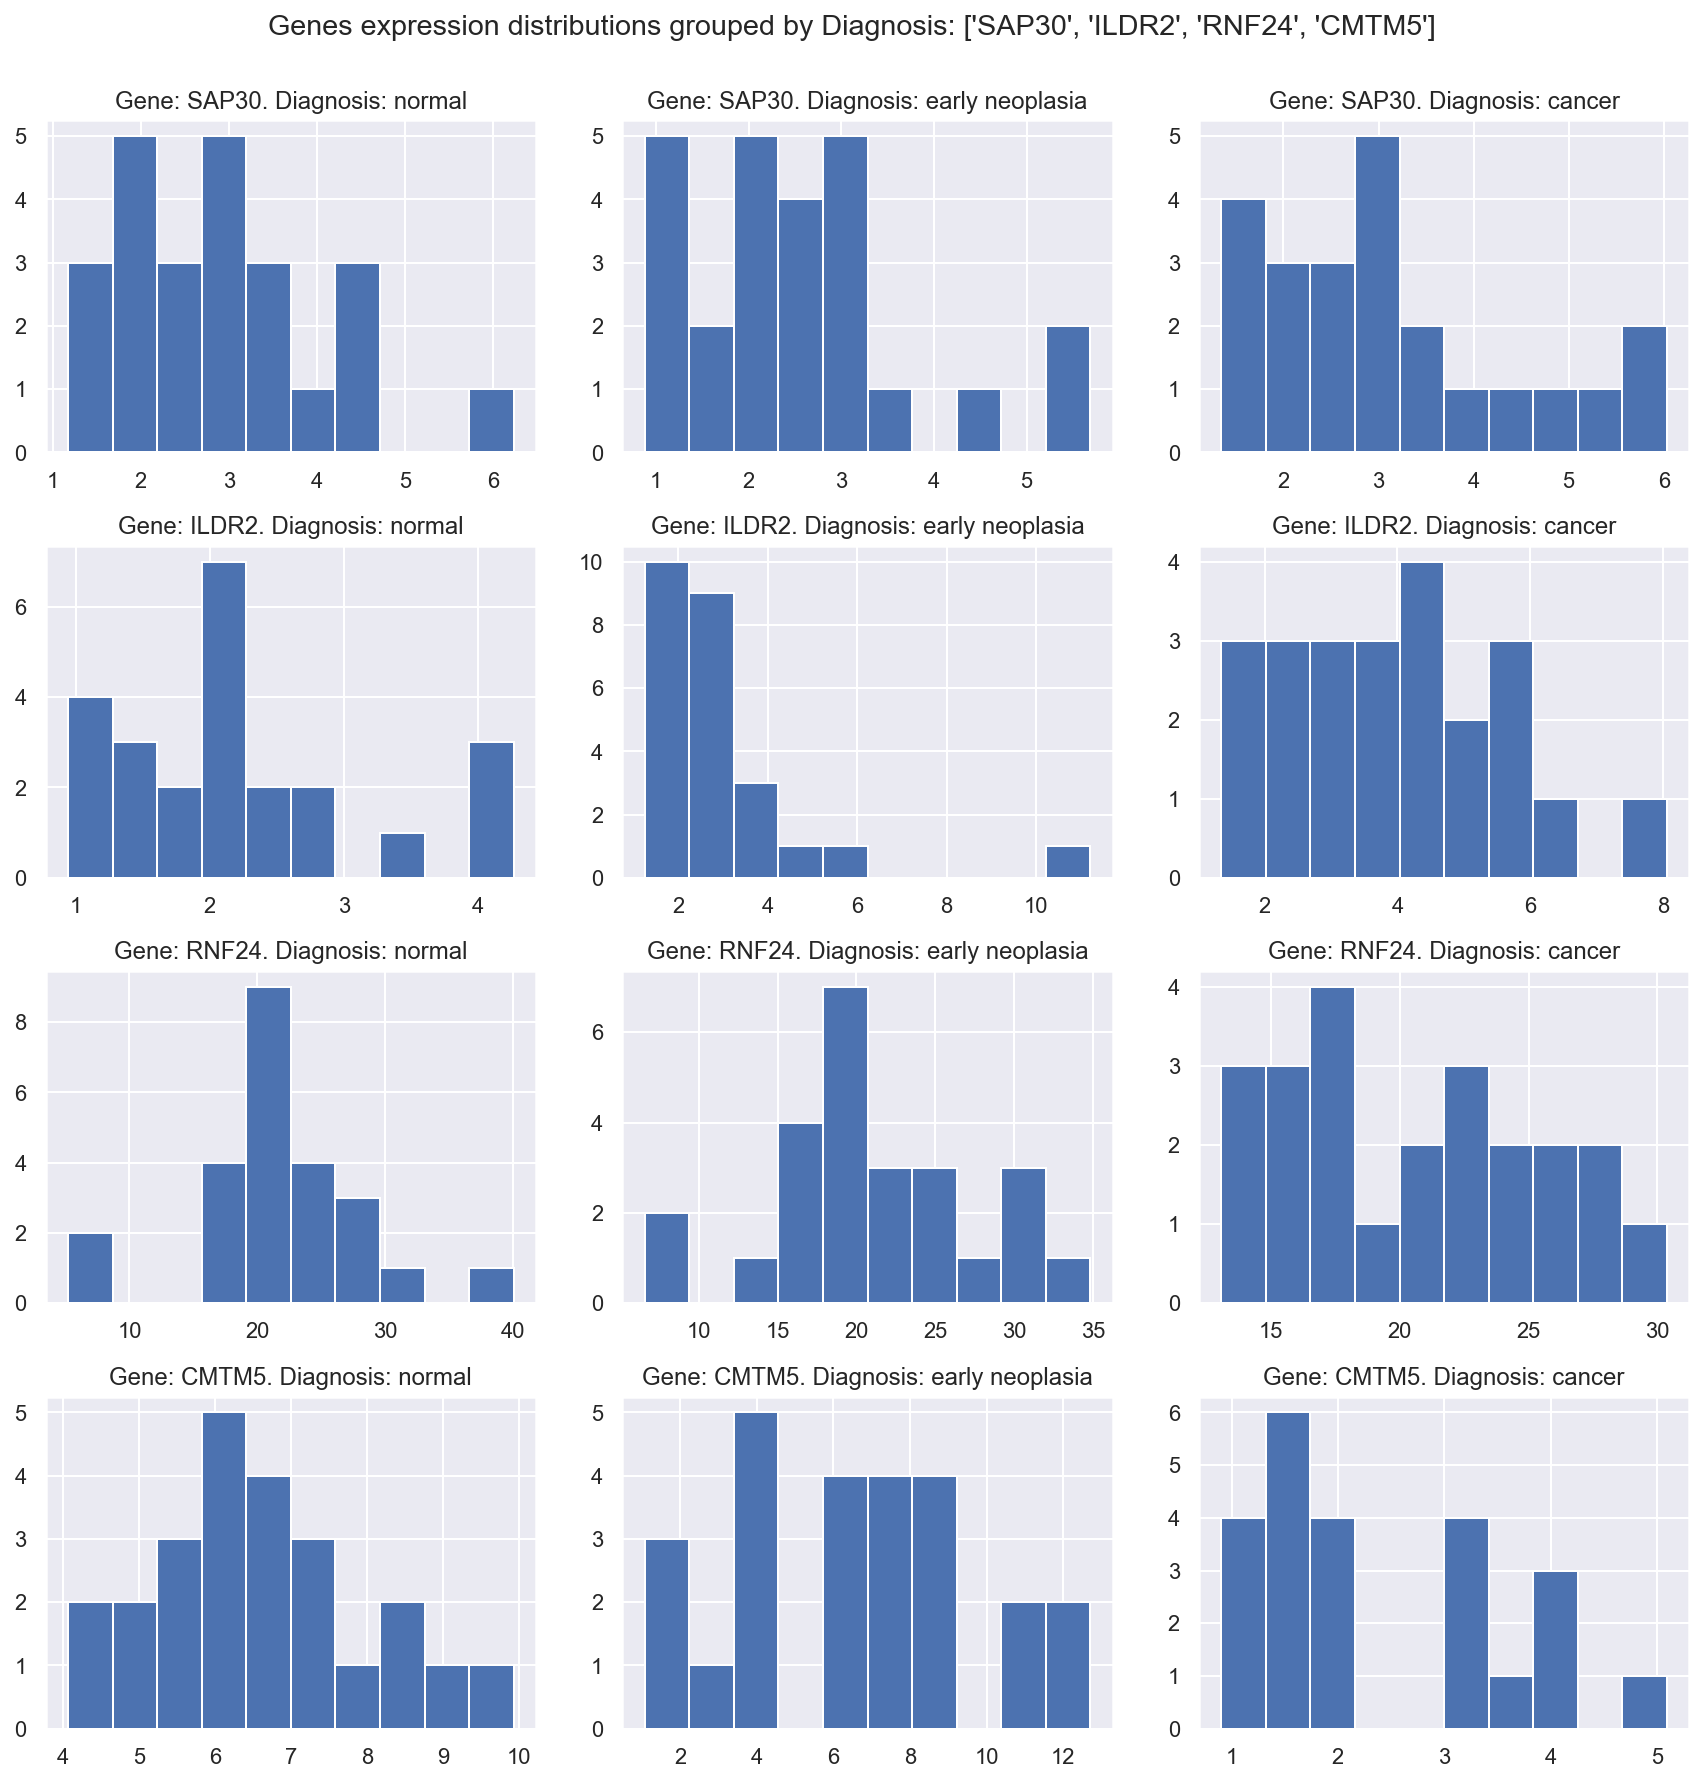

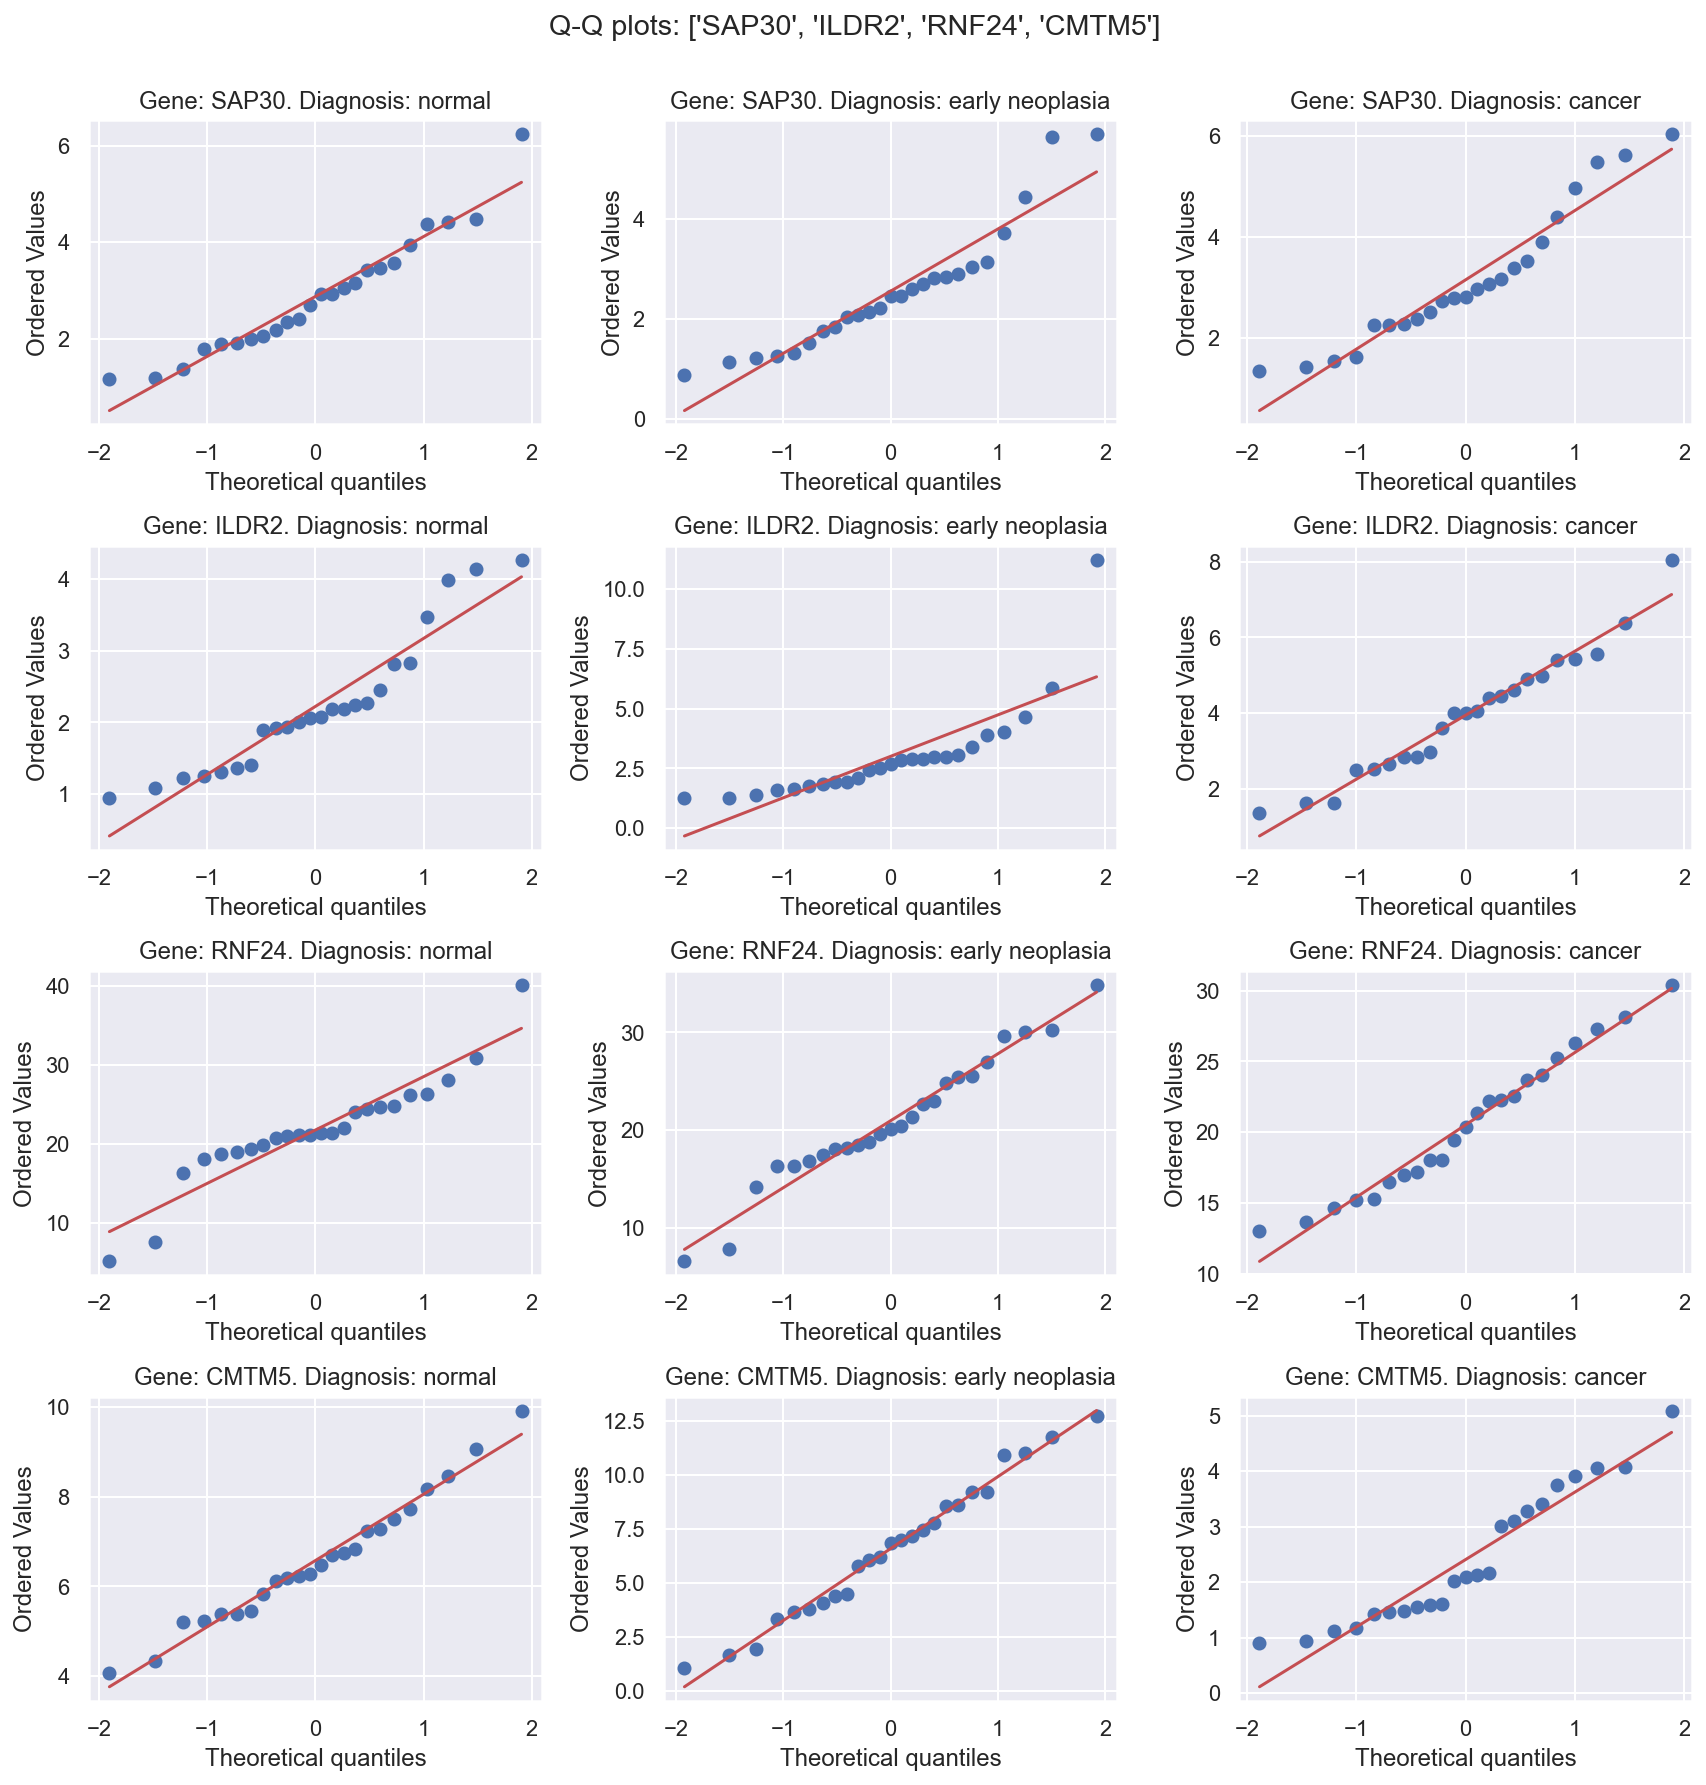

In [8]:
gene_list = df.columns.tolist()[2:]
np.random.seed(42)
np.random.shuffle(gene_list)
diagnosis = df['Diagnosis'].unique().tolist()
ncols, nrows = 3, 4

# Графики распределения значений выборок
fig, axes = plt.subplots(nrows, ncols, figsize=(12,12))
for i, g in enumerate(gene_list[:nrows]):
    for j, d in enumerate(diagnosis):
        df[df['Diagnosis']==d][g].hist(ax=axes[i][j])
        axes[i][j].set_title(f'Gene: {g}. Diagnosis: {d}')
        
plt.suptitle(f'Genes expression distributions grouped by Diagnosis: {gene_list[:nrows]}', x =0.5, y=1.03)
plt.tight_layout(pad=1.1)
plt.show()

# Q-Q-графики
fig, axes = plt.subplots(nrows, ncols, figsize=(12,12))
for i, g in enumerate(gene_list[:nrows]):
    for j, d in enumerate(diagnosis):
        scipy.stats.probplot(df[df['Diagnosis']==d][g], dist="norm", plot=axes[i][j])
        axes[i][j].set_title(f'Gene: {g}. Diagnosis: {d}')
        
plt.suptitle(f'Q-Q plots: {gene_list[:nrows]}', x =0.5, y=1.03)
plt.tight_layout(pad=1.1)
plt.show()

__Пункт 1.__ Для каждого гена из 15748 необходимо проверить гипотезу различия среднего значения его экспрессии между группами: 

 * normal и early neoplasia
 * early neoplasia и cancer

Поскольку заранее не поставлено дополнительных предположений, в какую сторону экспрессия того или иного гена может быть смещена в различных группах, используем `двухвыборочный двухсторонний тест Стьюдента для независимых выборок`. 

Однако в постановке задачи совсем не упомянуто про проверку основной предпосылки возможности использования теста Стьюдента:

 1. `Нормальность выборок`. Поэтому перед тестированием будем проводить проверку на нормальность с использованием теста Шапиро-Уилка. 
 
 
 2. Также поскольку размеры выборок для каждой из групп различны с точностью до одного наблюдения, а дисперсии  заранее неизвестны, как и неизвестно, равны ли дисперсии в группах между собой, возникает `проблема Беренца-Фишера`. Для решения данной проблемой будем пользоваться t-тестом Уэлча, который является приближенным решением проблемы Беренца-Фишера. При этом тест Уэлча продолжает требовать нормального распределения данных. В scipy тест Уэлча помещен в `ttest_ind`, запускается в случае выставления параметра неравной вариации выборок `equal_var=False`.
 
Несмотря на постановку задачи обязательного использования теста Стьюдента, будем параллельно использовать `непараметрический тест: перестановочный критерий`, поскольку гистограммы распределений, а также Q-Q графики показывают, что присутствует некоторое отклонение от нормальности.

Также подчеркнем, что вначале проанализируем результаты без поправок на множественные сравнения. Далее этому посвящены следующие задачи.

In [9]:
alpha = 0.05

In [10]:
df.head()

,Patient_id,Diagnosis,LOC643837,LOC100130417,SAMD11,NOC2L,KLHL17,PLEKHN1,C1orf170,HES4,...,CLIC2,RPS4Y1,ZFY,PRKY,USP9Y,DDX3Y,CD24,CYorf15B,KDM5D,EIF1AY
0,STT5425_Breast_001_normal,normal,1.257614,2.408148,13.368622,9.494779,20.880435,12.722017,9.494779,54.349694,...,4.761250,1.257614,1.257614,1.257614,1.257614,1.257614,23.268694,1.257614,1.257614,1.257614
1,STT5427_Breast_023_normal,normal,4.567931,16.602734,42.477752,25.562376,23.221137,11.622386,14.330573,72.445474,...,6.871902,1.815112,1.815112,1.815112,1.815112,1.815112,10.427023,1.815112,1.815112,1.815112
2,STT5430_Breast_002_normal,normal,2.077597,3.978294,12.863214,13.728915,14.543176,14.141907,6.232790,57.011005,...,7.096343,2.077597,2.077597,2.077597,2.077597,2.077597,22.344226,2.077597,2.077597,2.077597
3,STT5439_Breast_003_normal,normal,2.066576,8.520713,14.466035,7.823932,8.520713,2.066576,10.870009,53.292034,...,5.200770,2.066576,2.066576,2.066576,2.066576,2.066576,49.295538,2.066576,2.066576,2.066576
4,STT5441_Breast_004_normal,normal,2.613616,3.434965,12.682222,10.543189,26.688686,12.484822,1.364917,67.140393,...,11.227770,1.364917,1.364917,1.364917,1.364917,1.364917,23.627911,1.364917,1.364917,1.364917


In [11]:
# Проведем тест Шапиро-Уилка:
# H0: распределение нормально
# H1: распределние не нормально
normal_test_dict = {'Diagnosis':[], 'Gene': [], 'p_value': []}
for g in tqdm.tqdm_notebook(df.columns.tolist()[2:]):
    for d in df['Diagnosis'].unique():
        _, p_value = scipy.stats.shapiro(df[df['Diagnosis']==d][g].values)
        normal_test_dict['Diagnosis'].append(d)
        normal_test_dict['Gene'].append(g)
        normal_test_dict['p_value'].append(p_value)

C:\Users\alrpo\.conda\envs\exp_env\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [12]:
df_shapiro_test = pd.DataFrame(normal_test_dict)
# Проверим, что тесты на нормальность проведены для всех выборок
print('All Shapiro-Wilk tests was made: ',
      len(df.columns.tolist()[2:])*df['Diagnosis'].nunique()==df_shapiro_test.shape[0])
df_shapiro_test.head()

All Shapiro-Wilk tests was made:  True


,Diagnosis,Gene,p_value
0,normal,LOC643837,0.017408
1,early neoplasia,LOC643837,0.015890
2,cancer,LOC643837,0.003103
3,normal,LOC100130417,0.000004
4,early neoplasia,LOC100130417,0.213321


In [13]:
df_shapiro_test.shape

(47244, 3)

In [14]:
print(f'Процент выборок, в которых гипотеза о нормальности с помощью теста Шапиро-Уилка отвергается с alpha={alpha}:', 
      round(100*df_shapiro_test[df_shapiro_test['p_value']<alpha].shape[0]/df_shapiro_test.shape[0],2 ),'%')

Процент выборок, в которых гипотеза о нормальности с помощью теста Шапиро-Уилка отвергается с alpha=0.05: 26.08 %


Соответственно, строго подходя к вопросу, для 26.08% выборок нарушается предпосылка нормальности. Необходимо использовать непараметрические тесты, не предполагающие наличие нормального распределения в данных, например, перестановочный критерий. 
Проведем все 2 теста на имеющихся данных.


Будем использовать следующие сокращения
* Mean in group: "normal" = mean in group: "early neoplasia", `n_en`
* Mean in group: "early neoplasia" = mean in group: "cancer", `en_c`

In [15]:
# Для ускорения вычислений распараллелим процесс подсчета достаточного уровня значимости по двум тестам
# Для этого был сделан отдельный multi_test.py файл.
# Измеренное время выполнения: 2640.5921 sec, для удобства был сохранен датафрейм после вычислений.
import multi_test as mtest

In [16]:
df_tested = pd.read_csv('df_tested.csv')

In [17]:
df_tested.reset_index(inplace=True, drop=True)
df_tested_original = df_tested.copy(deep=True)
df_tested.head()

,Gene,n_en_student_p_value,en_c_student_p_value,n_en_permutation_p_value,en_c_permutation_p_value
0,LOC643837,0.690766,0.413735,0.6889,0.4217
1,LOC100130417,0.000032,0.653429,0.0001,0.6551
2,SAMD11,0.060273,0.079556,0.0600,0.0652
3,NOC2L,0.826429,0.287581,0.8246,0.2902
4,KLHL17,0.049876,0.463292,0.0502,0.4721


In [18]:
df_tested.shape

(15748, 5)

Посмотрим различия между t-тестом Уэлча и перестановочным критерием.

In [19]:
# Mean in group: "normal" = mean in group: "early neoplasia"
# Число отвергаемых нулевых гипотез => отвергаются равные значения средней экспрессии
print('H0 rejected:')
print(f"""Student test: {df_tested[df_tested['n_en_student_p_value']<alpha].shape[0]}/{df_tested.shape[0]}""")
print(f"""Permutation test: {df_tested[df_tested['n_en_permutation_p_value']<alpha].shape[0]}/{df_tested.shape[0]}""")

H0 rejected:
Student test: 1575/15748
Permutation test: 1596/15748


In [20]:
# Mean in group: "early neoplasia" = mean in group: "cancer"
# Число отвергаемых нулевых гипотез => отвергаются равные значения средней экспрессии
print('H0 rejected:')
print(f"""Student test: {df_tested[df_tested['en_c_student_p_value']<alpha].shape[0]}/{df_tested.shape[0]}""")
print(f"""Permutation test: {df_tested[df_tested['en_c_permutation_p_value']<alpha].shape[0]}/{df_tested.shape[0]}""")

H0 rejected:
Student test: 3490/15748
Permutation test: 3552/15748


__Соответственно__: 

Количество статистически значимых отличий (число генов) для теста Стьюдента (Уэлча) составляет:

 * Для оценки отличия между normal и early neoplasia: 1575 из 15748
 * Для оценки отличия между early neoplasia и cancer: 3490 из 15748
 
Интересно, что перестановочный критерий дал больше статистически значимых отличий:
 * Для оценки отличия между normal и early neoplasia: 1596 из 15748, (+21)
 * Для оценки отличия между early neoplasia и cancer: 3552 из 15748, (+62)

In [21]:
# Отфильтруем те гены, выборки по которым оказались не нормальными по тесту Шапиро-Уилка:
shapiro_reject_genes = df_shapiro_test[df_shapiro_test['p_value']<alpha]['Gene'].unique().tolist()
len(shapiro_reject_genes)

7781

In [22]:
print(f"""Student test: {df_tested[(df_tested['n_en_student_p_value']<alpha)&
                                   (~df_tested['Gene'].isin(shapiro_reject_genes))].shape[0]}/{df_tested.shape[0]}""")

Student test: 658/15748


In [23]:
print(f"""Student test: {df_tested[(df_tested['en_c_student_p_value']<alpha)&
                                   (~df_tested['Gene'].isin(shapiro_reject_genes))].shape[0]}/{df_tested.shape[0]}""")

Student test: 1685/15748


Соответственно, с учетом фильтрации данных от тех генов, гипотеза о нормальности значений экспрессии по которым отвергается, число статистически значимых отличий уменьшается более чем в два раза.

---

__Пункт 2.__ Применить поправку Холма для получившихся двух наборов достигаемых уровней значимости, а также поправку Бонферони после поправки Холма (т.е. использовать уровень значимости 0.05 / 2 вместо 0.05 для дальнейшего уточнения значений p-value c помощью метода Холма.). Посчитать для каждого значимого изменения `fold change` и выписать в ответ число таких значимых изменений, абсолютное значение fold change которых __`> 1.5`__.

In [24]:
# Используем поправку Холма
for c in df_tested.columns.tolist()[1:]:
    _, p_vals_corrected, _, _ = multitest.multipletests(df_tested[c].values,alpha=alpha, method='holm')
    df_tested[f'{c}_holm'] = p_vals_corrected

In [25]:
df_tested.columns

Index(['Gene', 'n_en_student_p_value', 'en_c_student_p_value',
       'n_en_permutation_p_value', 'en_c_permutation_p_value',
       'n_en_student_p_value_holm', 'en_c_student_p_value_holm',
       'n_en_permutation_p_value_holm', 'en_c_permutation_p_value_holm'],
      dtype='object')

In [26]:
# Интересно, что перестановочный критерий после поправки Холма не отвергает ни одну из нулевых гипотез
df_tested[df_tested['n_en_permutation_p_value_holm']<alpha]

,Gene,n_en_student_p_value,en_c_student_p_value,n_en_permutation_p_value,en_c_permutation_p_value,n_en_student_p_value_holm,en_c_student_p_value_holm,n_en_permutation_p_value_holm,en_c_permutation_p_value_holm


In [27]:
df_tested[df_tested['en_c_permutation_p_value_holm']<alpha]

,Gene,n_en_student_p_value,en_c_student_p_value,n_en_permutation_p_value,en_c_permutation_p_value,n_en_student_p_value_holm,en_c_student_p_value_holm,n_en_permutation_p_value_holm,en_c_permutation_p_value_holm


In [28]:
df_tested = df_tested[['Gene', 'n_en_student_p_value', 'en_c_student_p_value',
                       'n_en_student_p_value_holm', 'en_c_student_p_value_holm']]
df_tested.head()

,Gene,n_en_student_p_value,en_c_student_p_value,n_en_student_p_value_holm,en_c_student_p_value_holm
0,LOC643837,0.690766,0.413735,1.000000,1.0
1,LOC100130417,0.000032,0.653429,0.500174,1.0
2,SAMD11,0.060273,0.079556,1.000000,1.0
3,NOC2L,0.826429,0.287581,1.000000,1.0
4,KLHL17,0.049876,0.463292,1.000000,1.0


Применим поправку Бонферонни с помощью альтернативного преобразования, взяв `min(1, 2*p_value)`
для столбцов `n_en_student_p_value_holm, en_c_student_p_value_holm`, чтобы не сравнивать все p_value с 0.025, а подойти к этому системно.

In [29]:
for column in ['n_en_student_p_value_holm', 'en_c_student_p_value_holm' ]:
    df_tested[column] = df_tested[column].apply(lambda x: min([1, 2*x]))
df_tested.rename(columns = {'n_en_student_p_value_holm': 'n_en_student_p_value_holm_bonf',
                            'en_c_student_p_value_holm': 'en_c_student_p_value_holm_bonf',
                           }, inplace=True)

In [30]:
df_tested.head()

,Gene,n_en_student_p_value,en_c_student_p_value,n_en_student_p_value_holm_bonf,en_c_student_p_value_holm_bonf
0,LOC643837,0.690766,0.413735,1.0,1.0
1,LOC100130417,0.000032,0.653429,1.0,1.0
2,SAMD11,0.060273,0.079556,1.0,1.0
3,NOC2L,0.826429,0.287581,1.0,1.0
4,KLHL17,0.049876,0.463292,1.0,1.0


In [31]:
df_tested[df_tested['n_en_student_p_value_holm_bonf']<alpha]

,Gene,n_en_student_p_value,en_c_student_p_value,n_en_student_p_value_holm_bonf,en_c_student_p_value_holm_bonf
7244,PCSK4,7.955435e-07,0.093955,0.025055,1.0
9820,EEF1A2,8.498742e-08,0.574408,0.002677,1.0


In [32]:
df_tested[df_tested['en_c_student_p_value_holm_bonf']<alpha]

,Gene,n_en_student_p_value,en_c_student_p_value,n_en_student_p_value_holm_bonf,en_c_student_p_value_holm_bonf
47,GABRD,0.003017,2.276043e-07,1.0,0.007150
283,EXTL1,0.077901,1.087046e-07,1.0,0.003417
316,CD164L2,0.902812,1.002085e-06,1.0,0.031415
1105,NES,0.383667,1.041679e-07,1.0,0.003275
1238,FMO2,0.123447,1.103311e-06,1.0,0.034584
...,...,...,...,...,...
15090,LAMC3,0.112352,1.938708e-09,1.0,0.000061
15449,SLC7A3,0.241312,3.981097e-08,1.0,0.001252
15576,CAPN6,0.306543,7.554205e-08,1.0,0.002375
15640,GPC3,0.011021,5.832350e-07,1.0,0.018303


In [33]:
df_tested_reduced = df_tested[(df_tested['n_en_student_p_value_holm_bonf']<alpha)|
                              (df_tested['en_c_student_p_value_holm_bonf']<alpha)].copy(deep=True)
df_tested_reduced.reset_index(inplace=True, drop=True)
df_tested_reduced

,Gene,n_en_student_p_value,en_c_student_p_value,n_en_student_p_value_holm_bonf,en_c_student_p_value_holm_bonf
0,GABRD,0.003017,2.276043e-07,1.0,0.007150
1,EXTL1,0.077901,1.087046e-07,1.0,0.003417
2,CD164L2,0.902812,1.002085e-06,1.0,0.031415
3,NES,0.383667,1.041679e-07,1.0,0.003275
4,FMO2,0.123447,1.103311e-06,1.0,0.034584
...,...,...,...,...,...
76,LAMC3,0.112352,1.938708e-09,1.0,0.000061
77,SLC7A3,0.241312,3.981097e-08,1.0,0.001252
78,CAPN6,0.306543,7.554205e-08,1.0,0.002375
79,GPC3,0.011021,5.832350e-07,1.0,0.018303


Таким образом, количество статистически значимых отличий (число генов) для теста Стьюдента (Уэлча) c учетом поправки Холма-Бонферони составляет:

   * Для оценки отличия между normal и early neoplasia: 2 из 15748;
   * Для оценки отличия между early neoplasia и cancer: 79 из 15748.
   
Теперь скорректируем данный результат на уровень практической значимости, посчитав `fold change` для каждой из двух пар контроля и влияния. Расчет fold change осуществим уже на скоращенной выборке генов, по которым получена статистическая значимость различий с учетом поправки Холма-Бонферони.

In [34]:
def fold_change(control_mean, treatment_mean):
    if treatment_mean>control_mean:
        return treatment_mean/control_mean
    elif treatment_mean<control_mean:
        # Поскольку важно учесть абсолютное значение, опустим знак "-"
        return control_mean/treatment_mean
    else:
        return 1

In [35]:
# Сформируем удобную для присоединения к df_tested_reduced таблицу
reduced_gene_list = df_tested_reduced['Gene']
fold_change_dict = {'fold_change_n_en': [],
                    'fold_change_en_c': [],
                    'Gene': [],
                   }
for gene in tqdm.notebook.tqdm(reduced_gene_list):
    tmp_dict = df.groupby(by=['Diagnosis'])[gene].mean().to_dict()
    fold_change_dict['fold_change_n_en'].append(fold_change(tmp_dict['normal'], tmp_dict['early neoplasia']))
    fold_change_dict['fold_change_en_c'].append(fold_change(tmp_dict['early neoplasia'], tmp_dict['cancer']))
    fold_change_dict['Gene'].append(gene)
df_fold_change = pd.DataFrame(fold_change_dict)

In [36]:
df_fold_change.head()

,fold_change_n_en,fold_change_en_c,Gene
0,1.311855,1.843860,GABRD
1,1.226580,2.383210,EXTL1
2,1.012145,1.997381,CD164L2
3,1.059548,1.693428,NES
4,1.137142,1.795640,FMO2


In [37]:
df_tested_reduced = df_tested_reduced.merge(df_fold_change, how='left', on=['Gene'])

In [38]:
df_tested_reduced[(df_tested_reduced['n_en_student_p_value_holm_bonf']<alpha)&
                  (df_tested_reduced['fold_change_n_en']>1.5)]

,Gene,n_en_student_p_value,en_c_student_p_value,n_en_student_p_value_holm_bonf,en_c_student_p_value_holm_bonf,fold_change_n_en,fold_change_en_c
30,PCSK4,7.955435e-07,0.093955,0.025055,1.0,1.509785,1.176008
42,EEF1A2,8.498742e-08,0.574408,0.002677,1.0,1.974868,1.120771


In [39]:
df_tested_reduced[(df_tested_reduced['en_c_student_p_value_holm_bonf']<alpha)&
                  (df_tested_reduced['fold_change_en_c']>1.5)]

,Gene,n_en_student_p_value,en_c_student_p_value,n_en_student_p_value_holm_bonf,en_c_student_p_value_holm_bonf,fold_change_n_en,fold_change_en_c
0,GABRD,0.003017,2.276043e-07,1.0,0.007150,1.311855,1.843860
1,EXTL1,0.077901,1.087046e-07,1.0,0.003417,1.226580,2.383210
2,CD164L2,0.902812,1.002085e-06,1.0,0.031415,1.012145,1.997381
3,NES,0.383667,1.041679e-07,1.0,0.003275,1.059548,1.693428
4,FMO2,0.123447,1.103311e-06,1.0,0.034584,1.137142,1.795640
...,...,...,...,...,...,...,...
76,LAMC3,0.112352,1.938708e-09,1.0,0.000061,1.172109,2.868940
77,SLC7A3,0.241312,3.981097e-08,1.0,0.001252,1.161341,3.224495
78,CAPN6,0.306543,7.554205e-08,1.0,0.002375,1.135520,2.559150
79,GPC3,0.011021,5.832350e-07,1.0,0.018303,1.285565,1.870434


Таким образом, количество статистически и практически значимых отличий (число генов) для теста Стьюдента (Уэлча) с поправкой Холма-Бонферони составляет:

   * Для оценки отличия между normal и early neoplasia: 2 из 15748, это гены `EEF1A2`, `PCSK4`;
   * Для оценки отличия между early neoplasia и cancer: 77 из 15748.

---

__Пункт 3.__ Применить поправку Бенджамина-Хохберга для получившихся двух наборов достигаемых уровней значимости, а также поправку Бонферони после поправки Бенджамина-Хохберга (т.е. использовать уровень значимости 0.05 / 2 вместо 0.05 для дальнейшего уточнения значений p-value c помощью метода Холма.). Посчитать для каждого значимого изменения `fold change` и выписать в ответ число таких значимых изменений, абсолютное значение fold change которых __`> 1.5`__.

In [40]:
# Используем поправку Бенджамина-Хохберга
df_tested = df_tested_original.copy(deep=True)
for c in df_tested.columns.tolist()[1:]:
    _, p_vals_corrected, _, _ = multitest.multipletests(df_tested[c].values,alpha=alpha, method='fdr_bh')
    df_tested[f'{c}_fdr_bh'] = p_vals_corrected

In [41]:
df_tested.head()

,Gene,n_en_student_p_value,en_c_student_p_value,n_en_permutation_p_value,en_c_permutation_p_value,n_en_student_p_value_fdr_bh,en_c_student_p_value_fdr_bh,n_en_permutation_p_value_fdr_bh,en_c_permutation_p_value_fdr_bh
0,LOC643837,0.690766,0.413735,0.6889,0.4217,0.966511,0.675195,0.969886,0.683364
1,LOC100130417,0.000032,0.653429,0.0001,0.6551,0.035698,0.836406,0.038410,0.839287
2,SAMD11,0.060273,0.079556,0.0600,0.0652,0.536103,0.288873,0.526686,0.256052
3,NOC2L,0.826429,0.287581,0.8246,0.2902,0.980777,0.563007,0.982255,0.566865
4,KLHL17,0.049876,0.463292,0.0502,0.4721,0.499016,0.712214,0.493169,0.722300


In [42]:
# Поправка же Бенджамина-Хохберга оставила часть отвергаемых нулвых гипотез с помощью критерия перестановки
df_tested[df_tested['n_en_permutation_p_value_fdr_bh']<alpha]

,Gene,n_en_student_p_value,en_c_student_p_value,n_en_permutation_p_value,en_c_permutation_p_value,n_en_student_p_value_fdr_bh,en_c_student_p_value_fdr_bh,n_en_permutation_p_value_fdr_bh,en_c_permutation_p_value_fdr_bh
1,LOC100130417,0.000032,0.653429,0.0001,0.6551,0.035698,0.836406,0.038410,0.839287
64,ARHGEF16,0.000039,0.518975,0.0001,0.5273,0.035698,0.752566,0.038410,0.761548
194,ALDH4A1,0.000129,0.020553,0.0001,0.0211,0.050773,0.134359,0.038410,0.131441
295,ZNF683,0.000546,0.068045,0.0002,0.0504,0.086491,0.266422,0.048455,0.222200
429,SH3D21,0.000355,0.229427,0.0001,0.2258,0.077986,0.501738,0.038410,0.498723
...,...,...,...,...,...,...,...,...,...
14251,IKBKB,0.000044,0.676583,0.0001,0.6758,0.036654,0.849329,0.038410,0.851662
14534,RHPN1,0.000037,0.083406,0.0001,0.0853,0.035698,0.296428,0.038410,0.296339
14576,KIFC2,0.000020,0.214660,0.0001,0.2056,0.035698,0.486436,0.038410,0.477832
15171,KIAA1984,0.000531,0.126989,0.0002,0.1177,0.086491,0.370703,0.048455,0.354134


In [43]:
df_tested[df_tested['en_c_permutation_p_value_fdr_bh']<alpha]

,Gene,n_en_student_p_value,en_c_student_p_value,n_en_permutation_p_value,en_c_permutation_p_value,n_en_student_p_value_fdr_bh,en_c_student_p_value_fdr_bh,n_en_permutation_p_value_fdr_bh,en_c_permutation_p_value_fdr_bh
8,ISG15,0.240148,7.402400e-04,0.2358,0.0001,0.794398,0.017556,0.793449,0.004256
13,TNFRSF18,0.173205,2.093835e-03,0.1746,0.0017,0.738276,0.033551,0.740733,0.025594
17,FAM132A,0.006454,2.945987e-04,0.0061,0.0004,0.220483,0.009487,0.202237,0.010031
29,MRPL20,0.246598,3.843502e-03,0.2404,0.0031,0.800540,0.049330,0.798023,0.037844
35,C1orf70,0.398952,3.653727e-03,0.4103,0.0038,0.887442,0.047711,0.897389,0.043301
...,...,...,...,...,...,...,...,...,...
15700,SRPK3,0.036647,3.102974e-03,0.0395,0.0010,0.447725,0.042790,0.450432,0.018060
15703,PDZD4,0.221455,6.795085e-08,0.2265,0.0001,0.786524,0.000045,0.791592,0.004256
15705,AVPR2,0.402763,1.772694e-04,0.4054,0.0001,0.888415,0.007176,0.896853,0.004256
15723,PLXNA3,0.404461,5.072685e-03,0.4073,0.0037,0.888461,0.058006,0.897027,0.042593


In [44]:
df_tested = df_tested[['Gene', 'n_en_student_p_value', 'en_c_student_p_value',
                       'n_en_student_p_value_fdr_bh', 'en_c_student_p_value_fdr_bh']]
df_tested.head()

,Gene,n_en_student_p_value,en_c_student_p_value,n_en_student_p_value_fdr_bh,en_c_student_p_value_fdr_bh
0,LOC643837,0.690766,0.413735,0.966511,0.675195
1,LOC100130417,0.000032,0.653429,0.035698,0.836406
2,SAMD11,0.060273,0.079556,0.536103,0.288873
3,NOC2L,0.826429,0.287581,0.980777,0.563007
4,KLHL17,0.049876,0.463292,0.499016,0.712214


Применим поправку Бонферонни с помощью альтернативного преобразования, взяв `min(1, 2*p_value)`
для столбцов `n_en_student_p_value_fdr_bh, en_c_student_p_value_fdr_bh`, чтобы не сравнивать все p_value с 0.025, а подойти к этому системно.

In [45]:
for column in ['n_en_student_p_value_fdr_bh', 'en_c_student_p_value_fdr_bh' ]:
    df_tested[column] = df_tested[column].apply(lambda x: min([1, 2*x]))
df_tested.rename(columns = {'n_en_student_p_value_fdr_bh': 'n_en_student_p_value_fdr_bh_bonf',
                            'en_c_student_p_value_fdr_bh': 'en_c_student_p_value_fdr_bh_bonf',
                           }, inplace=True)

In [46]:
df_tested[df_tested['n_en_student_p_value_fdr_bh_bonf']<alpha]

,Gene,n_en_student_p_value,en_c_student_p_value,n_en_student_p_value_fdr_bh_bonf,en_c_student_p_value_fdr_bh_bonf
4627,TMEM63C,2.222228e-06,0.790244,0.017498,1.000000
7244,PCSK4,7.955435e-07,0.093955,0.012528,0.632581
8250,CACNG8,2.015472e-06,0.900649,0.017498,1.000000
9820,EEF1A2,8.498742e-08,0.574408,0.002677,1.000000


In [47]:
df_tested[df_tested['en_c_student_p_value_fdr_bh_bonf']<alpha]

,Gene,n_en_student_p_value,en_c_student_p_value,n_en_student_p_value_fdr_bh_bonf,en_c_student_p_value_fdr_bh_bonf
8,ISG15,0.240148,7.402400e-04,1.000000,0.035112
17,FAM132A,0.006454,2.945987e-04,0.440965,0.018975
44,GNB1,0.694046,1.154858e-03,1.000000,0.045984
47,GABRD,0.003017,2.276043e-07,0.320461,0.000172
54,PLCH2,0.574038,5.973956e-04,1.000000,0.030397
...,...,...,...,...,...
15654,NCRNA00086,0.770570,4.875591e-04,1.000000,0.026385
15692,BGN,0.174096,1.779494e-04,1.000000,0.014371
15694,DUSP9,0.078060,2.069987e-04,1.000000,0.015597
15703,PDZD4,0.221455,6.795085e-08,1.000000,0.000089


In [48]:
df_tested_reduced = df_tested[(df_tested['n_en_student_p_value_fdr_bh_bonf']<alpha)|
                              (df_tested['en_c_student_p_value_fdr_bh_bonf']<alpha)].copy(deep=True)
df_tested_reduced.reset_index(inplace=True, drop=True)
df_tested_reduced

,Gene,n_en_student_p_value,en_c_student_p_value,n_en_student_p_value_fdr_bh_bonf,en_c_student_p_value_fdr_bh_bonf
0,ISG15,0.240148,7.402400e-04,1.000000,0.035112
1,FAM132A,0.006454,2.945987e-04,0.440965,0.018975
2,GNB1,0.694046,1.154858e-03,1.000000,0.045984
3,GABRD,0.003017,2.276043e-07,0.320461,0.000172
4,PLCH2,0.574038,5.973956e-04,1.000000,0.030397
...,...,...,...,...,...
831,NCRNA00086,0.770570,4.875591e-04,1.000000,0.026385
832,BGN,0.174096,1.779494e-04,1.000000,0.014371
833,DUSP9,0.078060,2.069987e-04,1.000000,0.015597
834,PDZD4,0.221455,6.795085e-08,1.000000,0.000089


Таким образом, количество статистически значимых отличий (число генов) для теста Стьюдента (Уэлча) с поправкой  Бенджамина-Хохберга-Бонферони составляет:

   * Для оценки отличия между normal и early neoplasia: 4 из 15748;
   * Для оценки отличия между early neoplasia и cancer: 832 из 15748.
   
Теперь скорректируем данный результат на уровень практической значимости, посчитав `fold change` для каждой из двух пар контроля и влияния. Расчет fold change осуществим уже на скоращенной выборке генов, по которым получена статистическая значимость различий с учетом поправки Бенджамина-Хохберга-Бонферони.

In [49]:
# Сформируем удобную для присоединения к df_tested_reduced таблицу
reduced_gene_list = df_tested_reduced['Gene']
fold_change_dict = {'fold_change_n_en': [],
                    'fold_change_en_c': [],
                    'Gene': [],
                   }
for gene in tqdm.notebook.tqdm(reduced_gene_list):
    tmp_dict = df.groupby(by=['Diagnosis'])[gene].mean().to_dict()
    fold_change_dict['fold_change_n_en'].append(fold_change(tmp_dict['normal'], tmp_dict['early neoplasia']))
    fold_change_dict['fold_change_en_c'].append(fold_change(tmp_dict['early neoplasia'], tmp_dict['cancer']))
    fold_change_dict['Gene'].append(gene)
df_fold_change = pd.DataFrame(fold_change_dict)

In [50]:
df_tested_reduced = df_tested_reduced.merge(df_fold_change, how='left', on=['Gene'])

In [51]:
print(df_tested_reduced[(df_tested_reduced['n_en_student_p_value_fdr_bh_bonf']<alpha)&
                  (df_tested_reduced['fold_change_n_en']>1.5)].shape)
df_tested_reduced[(df_tested_reduced['n_en_student_p_value_fdr_bh_bonf']<alpha)&
                  (df_tested_reduced['fold_change_n_en']>1.5)]

(4, 7)


,Gene,n_en_student_p_value,en_c_student_p_value,n_en_student_p_value_fdr_bh_bonf,en_c_student_p_value_fdr_bh_bonf,fold_change_n_en,fold_change_en_c
245,TMEM63C,2.222228e-06,0.790244,0.017498,1.000000,1.663826,1.026958
384,PCSK4,7.955435e-07,0.093955,0.012528,0.632581,1.509785,1.176008
441,CACNG8,2.015472e-06,0.900649,0.017498,1.000000,1.754951,1.031444
524,EEF1A2,8.498742e-08,0.574408,0.002677,1.000000,1.974868,1.120771


In [52]:
print(df_tested_reduced[(df_tested_reduced['en_c_student_p_value_fdr_bh_bonf']<alpha)&
                  (df_tested_reduced['fold_change_en_c']>1.5)].shape)
df_tested_reduced[(df_tested_reduced['en_c_student_p_value_fdr_bh_bonf']<alpha)&
                  (df_tested_reduced['fold_change_en_c']>1.5)]

(524, 7)


,Gene,n_en_student_p_value,en_c_student_p_value,n_en_student_p_value_fdr_bh_bonf,en_c_student_p_value_fdr_bh_bonf,fold_change_n_en,fold_change_en_c
0,ISG15,0.240148,7.402400e-04,1.000000,0.035112,1.066094,2.458867
3,GABRD,0.003017,2.276043e-07,0.320461,0.000172,1.311855,1.843860
6,AJAP1,0.000956,7.993294e-04,0.216677,0.036539,1.554923,1.567814
7,CA6,0.919820,7.806213e-04,1.000000,0.036157,1.013860,1.736762
9,MASP2,0.000386,9.522413e-05,0.155971,0.010098,1.686021,1.750200
...,...,...,...,...,...,...,...
830,GPC3,0.011021,5.832350e-07,0.557180,0.000312,1.285565,1.870434
831,NCRNA00086,0.770570,4.875591e-04,1.000000,0.026385,1.036978,1.615783
832,BGN,0.174096,1.779494e-04,1.000000,0.014371,1.216664,1.763462
833,DUSP9,0.078060,2.069987e-04,1.000000,0.015597,1.344027,2.173490


Таким образом, количество статистически и практически значимых отличий (число генов) для теста Стьюдента (Уэлча) с поправкой Бенджамина-Хохберга-Бонферони. составляет:

   * Для оценки отличия между normal и early neoplasia: 4 из 15748, это гены `TMEM63C, PCSK4, CACNG8, EEF1A2`. 
   * Для оценки отличия между early neoplasia и cancer: 524 из 15748.
   
Причем `EEF1A2 и PCSK4` имеют статистичеси значимые различия в средних уровнях экспрессии при __двух вариантах поправки на множественное сравнение__ (Холма-Бонферони, Бенджамина-Хохберга-Бонферони), в результате чего стоит обязательно более детально исследовать эти гены, поскольку это касается статистически значимого различия между __здоровыми людьми и людьми с ранней формой заболевания__. 